# Практическое задание

## Интерполяция байеровского шаблона (demosaicing)

### О задании

В этом задании вам предстоит познакомится с простейшими инструментами считывания и обработки изображений в python, и с помощью них реализовать и протестировать 2 метода интерполяции байеровского шаблона. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. 
Вам понадобится работать со следущими пакетами:

* [`numpy`](https://docs.scipy.org/doc/numpy/reference/index.html) - библиотека для работы с многомерными масивами и матрицами, содержащая большое кол-во высокоуровневых математических функций для операций с этими масивами.  


* [`skimage`](http://scikit-image.org/) - библиотека, содержащие большую коллекцию алгоритмов для обработки изображений;

* [`scipy`](https://www.scipy.org/) - библиотека, содержащая большой набор инструментов для математических и инженерных вычислений. Основная структура данных numpy массив.

* [`matplotlib`](https://matplotlib.org/) - библиотека для визуализации различных графиков, диаграмм, изображений и много другого.

In [1]:
#!pip install numpy scikit-image scipy matplotlib

### Общая информация

Фильтр Байера - это матрица цветных фильтров для фотосенсора фотоаппарта. Каждая ячейка матрицы представляет собой фильтр одного из цветов R, G или B. В классическом фильтре Байера применяются светофильтры трёх основных цветов в следующем порядке: <img src="bayer_pat.png" width="50">
Матрица является устройством, воспринимающим спроецированное на него изображение. Вследствие использования фильтров каждый фотоприемник воспринимает лишь 1/3 цветовой информации участка изображения, а 2/3 отсекается фильтром. Недостающие компоненты цвета рассчитываются процессором камеры на основании данных из соседних ячеек в результате интерполяции (demosaicing).
<img src="bayer.jpg" width="500">

Вам необходимо будет научиться востанавливать "полноцветное" изображение по байеровскому шаблону.

Вместе с заданием вам был выдан архив `data.zip`. В нем содержатся следущие данные:
* `raw/` - директория с  различными одноканальными изображениями, полученными с помощью фильтра Байера. Фильтр Байера который применялся, соответствует последовательности каналов(GRGB), показанной выше. В каждом пикселе изображения записан отклик фильтра соответсвующего цвета;
* `gt/` - директория с *ground truth* изображениями, каждому raw-изображению из предыдущей директории существует изображение из этой директории(с тем же именем) с истинными значениями RGB-канналов в каждом пикселе;
* `debug/` - изображения для самопроверки работы алгоритмов.

Выполненный нотбук сдается вместе с папкой `results`, где должны лежать результаты работы алгоритмов. Ниже будет описано подробнее. Все необходимо заархивировать в один zip файл.

### Практическая часть

In [1]:
import skimage.io
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
GT_DIR = 'data/gt/'
RAW_DIR = 'data/raw/'

**1. (0.5 балла)**

Считайте raw и ground truth изображения `IMG0001.bmp`, выведите в какой тип данных они считались(список, массив, ...?), какой тип данных у пикселей изображения(float, int, ...?), размеры изображений.  Подумайте на тем как хранятся изображения в памяти.

Вам могут понадобиться:
* `skimage.io.imread(..)`

**Hint**: в jupyter-notebook если после ввода названия функции нажать сочетание клавиш `shift+tab` , выведется докстринг этой функции.

In [3]:
gt_image = skimage.io.imread(GT_DIR + 'IMG0001.bmp')
raw_image = skimage.io.imread(RAW_DIR + 'IMG0001.bmp')

print("Тип считанного изображения:", type(gt_image))
print('Типы элементов матриц:', gt_image.dtype, raw_image.dtype)
print("Размеры:", gt_image.shape, raw_image.shape)

Тип считанного изображения: <class 'numpy.ndarray'>
Типы элементов матриц: uint8 uint8
Размеры: (512, 768, 3) (512, 768)


Теперь давайте посмотрим на считанные изображения. Для этого воспользуемся:
* `matplotlib.pyplot.subplots(...)` для создания фигуры, заданного размера, с нужным нам количеством окон
* `matplotlib.axes.Axes.imshow(...)` методом объекта `matplotlib.axes.Axes` для вывода изображения

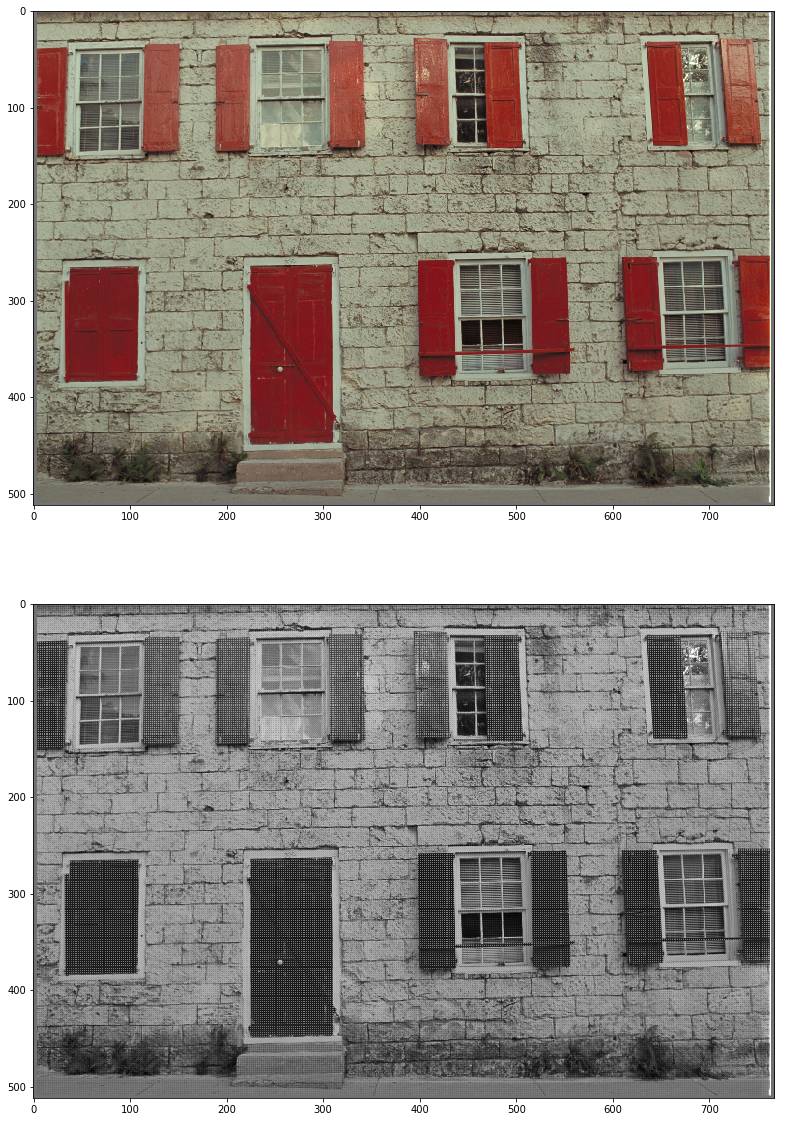

In [4]:
figure, axs = plt.subplots(2, 1, figsize=(15, 20))

axs[0].imshow(gt_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

**2. (0.5 балла)**

Перейдем непосредственного к интерепполяции байеровского шаблона.
Напишите вспомогательную функцию, которая для заданного размера raw-изображения создает маски для красных, зеленых и синих каналов байровского шаблона.

Вам могут понадобиться:
* `numpy.tile(...)`

In [5]:
def get_bayer_pattern_masks(h, w):
    """
    Get 3 masks for red, green, blue channels of bayer pattern size (h, w)

    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return: [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))],
    list of 3 mask, size (h, w) for red, green, blue channels respectively
    """
    r_filter = np.array([[0, 1], [0, 0]])
    g_filter = np.array([[1, 0], [0, 1]])
    b_filter = np.array([[0, 0], [1, 0]])
    
    masks = tuple(map(
        lambda filter: np.tile(filter, (h // 2 + 1, w // 2 + 1))[:h, :w], 
        [r_filter, g_filter, b_filter]
    )) 
    return masks

Проверьте правильность работы  функции с помощью простейшего теста.

In [6]:
# small test for self-examination
r, g, b = get_bayer_pattern_masks(3, 3) 
assert (r == np.array([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, 1, 0]]
)).all()
assert (g == np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]]
)).all()
assert (b == np.array([
    [0, 0, 0], 
    [1, 0, 1], 
    [0, 0, 0]]
)).all()

**3. (0.5 балла)**

Посмотрим, что на самом деле хранится в raw-изображениях. Напишите функцию, которая создает цветное изображение из raw-изображения следущим образом: в каждый цветовой канал поместите только известные пиксели из raw-изображения, пиксели, в которых данный цвет неизвестен, поставьте 0. Сохраните данное изображение в файл `results/colored_raw_image.bmp` и посмотрите что получилось.

Вам может пригодиться:
* `np.where(...)`
* `skimage.io.imsave(...)`

In [7]:
def get_colored_raw_image(raw_image):
    """
    Create colored raw image.
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), colored raw image
    """
        
    return np.array(
        [raw_image * pattern for pattern in get_bayer_pattern_masks(*raw_image.shape)], dtype=np.uint8
    ).transpose(1, 2, 0)

In [8]:
colored_raw_image = get_colored_raw_image(raw_image)
os.makedirs('results/', exist_ok=True)

skimage.io.imsave('results/colored_raw_image.bmp', colored_raw_image)

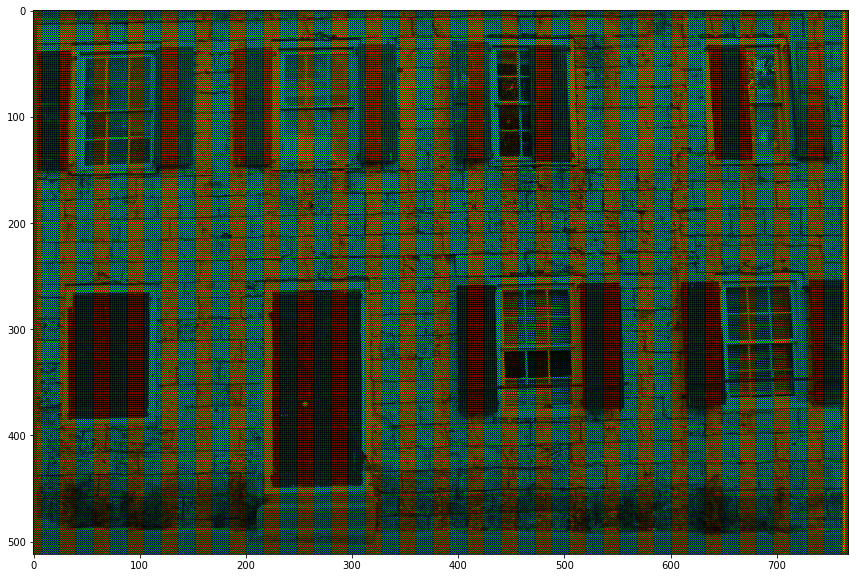

In [9]:
plt.figure(figsize=(15, 10))
plt.imshow(colored_raw_image)
plt.show()

**4. (3 балла)**

Напишите алгоритм билинейной интерполяции байеровского шаблона. В этом алгоритме **неизвестные** значения цветовых компонент вычисляются следущим образом:
* рассматривается окно 3x3 с центром в данном пикселе
* значение цветовой компоненты(r, g, или b) в данном пикселе вычисляется как среднее **заданных** значений данной цветовой компоненты пикселей в этом окне

Например, если, мы хотим интерполировать значение зеленой компоненты цвета в пикселе отмеченном '$+$' на рисунке, нам необходимо усреднить значение 4-х зеленых конпонент в 3x3 окрестности, отмеченных '$\cdot$' 

<img src="example.png" width="130">

В данном задание разрешается обходить матрицу и попиксельно вычислять цветовые компоненты. На будущих занятих вы познакомитесь с понятием "cвертка", и узнаете как на питоне можно было бы избежать обхода матрицы.

Вам может пригодиться:
* `numpy.stack(...)`
* `numpy.rint(...)`

**Замечания:** 
* Поведение на границе, где окно 3x3 неполное, выберите на свое усмотрение, при подсчете метрик оно учитываться не будет.
* Выполнение алгоритма на одном изображении не должно занимать более 20 секунд.
* Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [10]:
from itertools import product
def bilinear_interpolation(raw_image):
    """
    Perform bilinear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    
    masks = np.array(get_bayer_pattern_masks(*raw_image.shape)).transpose(1, 2, 0)
    kernel = np.ones([3, 3, 3])
    kernel[1, 1] = 1e6
    def convolve(image, i, j):
        if not (0 < i < image.shape[0] - 1 and 0 < j < image.shape[1] - 1): 
            u = max(i - 1, 0)
            d = min(i + 2, image.shape[0])
            l = max(j - 1, 0)
            r = min(j + 2, image.shape[1])
            ker = kernel[i == 0 : 3 - (i == image.shape[0] - 1), j == 0 : 3 - (j == image.shape[1] - 1)]
        else:
            u = i - 1
            d = i + 2
            l = j - 1
            r = j + 2
            ker = kernel
        return (image[u: d, l: r] * ker).sum(axis=(0, 1)) / (masks[u: d, l: r] * ker).sum(axis=(0, 1))
    
    image = np.zeros((*raw_image.shape, 3), dtype=np.float64)
    colored_raw_image = get_colored_raw_image(raw_image)
    for i, j in product(range(raw_image.shape[0]), range(raw_image.shape[1])):
        image[i, j] = convolve(colored_raw_image, i, j)

    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [11]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_bilinear.bmp')
diff = np.abs(bilinear_interpolation(raw_image) - image_true)[1:-1, 1:-1].sum()
assert diff == 0

Вычислите билинейную интерполяцию байеровского шаблона для всех изображений из директории `raw/` и сохраните в директорию `results/bilinear/`. Посмотрите на результаты интерполяции, сделайте выводы о плюсах и минусах этого алгоритма.

In [12]:
from tqdm import tqdm_notebook

OUTPUT_DIR = 'results/bilinear'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# your code here
for filename in tqdm_notebook(os.listdir(RAW_DIR)):
    raw_image = skimage.io.imread(os.path.join(RAW_DIR, filename))
    bi_image = bilinear_interpolation(raw_image)
    skimage.io.imsave(os.path.join(OUTPUT_DIR, filename), bi_image)

**Выводы:**

**5. (1 балл)**

Для численной оценки работы алгоритма билинейной интерполяции реализуйте следущие метрики качества:

* Mean squared error $mse(pred\_image, gt\_image) = \frac{1}{3 * h * w} \sum_{i=1}^{h} \sum_{j=1}^{w} \sum_{c=1}^{3} (gt\_image[i, j, c] - pred\_image[i,j,c])^2$ 

* Peak signal-to-noise ratio $psnr(pred\_image, gt\_image) = 10 \log_{10}{(\frac{max(gt\_image)^2}{mse(pred\_image, gt\_image)} )}$

где $gt\_image$ - истинное изображение, $pred\_image$ - предсказанное.

Вычислите среднее значение этих метрик для всего датасета. При подсчете метрик не учитывайте, границу изображения, длиной в 2 пикселя.

Вам может понадобиться:
* `numpy.ndarray.mean(...)`
* `numpy.ndarray.max(...)`
* `numpy.log10(...)`

**Замечание:** Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа, рекомендуется в самом начале вычислений преобразовать изображение в тип `float64`.

In [13]:
def mse_score(pred_image, gt_image):
    """
    Compute mean squared error
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image[2: -2, 2: -2].astype(np.float64)
    gt_image = gt_image[2: -2, 2: -2].astype(np.float64)

    return ((pred_image - gt_image)**2).mean()


def psnr_score(pred_image, gt_image):
    """
    Compute peak signal-to-noise ratio
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image[2: -2, 2: -2].astype(np.float64)
    gt_image = gt_image[2: -2, 2: -2].astype(np.float64)

    return 10 * np.log10(gt_image.max()**2 / ((pred_image - gt_image)**2).mean())

In [14]:
results = {}
for filename in os.listdir(RAW_DIR):
    gt_image = skimage.io.imread(os.path.join(GT_DIR, filename))
    pred_image = skimage.io.imread(os.path.join(OUTPUT_DIR, filename))
    results[filename] = (mse_score(pred_image, gt_image), psnr_score(pred_image, gt_image))

**6. (3.5 балла)**

Теперь реализуем более сложную версию линейной интерполяции баеровского шаблона. Прочитайте статью, выданную вам совместно с ноутбуком, и реализуйте предложенный в ней алгоритм. Вычислите интерполяцию для всех изображений и сохраните в директорию `results/improved/`. Посчитайте средние значения метрик качества. 

**Замечания по поводу алгоритма:**
* в работе указанные фильтры неотнормированны к единице(сумма коэффициентов не равняется 1), чтобы сохранить масштаб значений, коэффициенты необходимо отнормировать на сумму значений в данном фильтре;
* в результате указанных в работе фильтров могут получаться значения большие 255 и меньшие 0, вам необходимо отрезать слишком большие и слишком маленькие значения по крайним значениям(`numpy.clip`);
* веса фильтров были выписаны в массивы за вас для избежания лишних ошибок.

**Замечание:** Как никогда будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [15]:
weigths_0 = (1 / 8) * np.array([
    [ 0,  0, 1/2,  0,  0],
    [ 0, -1,   0, -1,  0],
    [-1,  4,   5,  4, -1],
    [ 0, -1,   0, -1,  0],
    [ 0,  0, 1/2,  0,  0]
])

weigths_1 = (1 / 8) * np.array([
    [  0,  0,  -1,  0,   0],
    [  0, -1,   4, -1,   0],
    [1/2,  0,   5,  0, 1/2],
    [  0, -1,   4, -1,   0],
    [  0,  0,  -1,  0,   0]
])

weigths_2 = (1 / 8) * np.array([
    [   0,  0, -3/2,  0,    0],
    [   0,  2,    0,  2,    0],
    [-3/2,  0,    6,  0, -3/2],
    [   0,  2,    0,  2,    0],
    [   0,  0, -3/2,  0,    0]
])

weigths_3 = (1 / 8) * np.array([
    [ 0,  0, -1,  0,  0],
    [ 0,  0,  2,  0,  0],
    [-1,  2,  4,  2, -1],
    [ 0,  0,  2,  0,  0],
    [ 0,  0, -1,  0,  0]
])

In [16]:
def improved_linear_interpolation(raw_image):
    """
    Improved linear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    def get_kernel(i, j):
        I = np.zeros([5, 5])
        I[2, 2] = 1
        if i % 2 == 0 and j % 2 == 1:  # red
            return np.array([I, weigths_3, weigths_2]).transpose(1, 2, 0)
        if i % 2 == 1 and j % 2 == 0:  # blue
            return np.array([weigths_2, weigths_3, I]).transpose(1, 2, 0)
        if i % 2 == 0 and j % 2 == 0:  # green: red row, blue column
            return np.array([weigths_0, I, weigths_1]).transpose(1, 2, 0)
        if i % 2 == 1 and j % 2 == 1:  # green: blue row, red column
            return np.array([weigths_1, I, weigths_0]).transpose(1, 2, 0)
    
    def convolve(image, i, j):
        kernel = get_kernel(i, j)
        if not (1 < i < image.shape[0] - 2 and 1 < j < image.shape[1] - 2): 
            u = max(i - 2, 0)
            d = min(i + 3, image.shape[0])
            l = max(j - 2, 0)
            r = min(j + 3, image.shape[1])
            ker = kernel[2 + u - i : 2 + d - i, 2 + l - j : 2 + r - j]
            ker = ker / ker.sum(axis=(0, 1))
        else:
            u = i - 2
            d = i + 3
            l = j - 2
            r = j + 3
            ker = kernel
            
        return (image[u: d, l: r, None] * ker).sum(axis=(0, 1))
    
    
    image = np.zeros((*raw_image.shape, 3), np.float64)
    for i, j in product(range(raw_image.shape[0]), range(raw_image.shape[1])):
        image[i, j] = convolve(raw_image, i, j)
    return np.rint(np.clip(image, 0, 255)).astype(np.uint8)

Проверьте правильность работы функции с помощью прmостейшего теста. 

In [17]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_improved.bmp')
diff = np.abs(improved_linear_interpolation(raw_image) - image_true)[2:-2, 2:-2].sum()
assert diff == 0

In [19]:
OUTPUT_DIR2 = 'results/improved/'
os.makedirs(OUTPUT_DIR2, exist_ok=True)

# your code here
for filename in tqdm_notebook(os.listdir(RAW_DIR)):
    raw_image = skimage.io.imread(os.path.join(RAW_DIR, filename))
    ili_image = improved_linear_interpolation(raw_image)
    skimage.io.imsave(os.path.join(OUTPUT_DIR2, filename), ili_image)

**7. (1 балл)**

Проведите сравненение двух алгоритмов. Сравните два алгоритма по метрикам качества. А также выберите сложные моменты("окна" изображениях) для интерполяции и визуализируйте эти "окна". Сравнивайте работу первого алгоритма, второго алгоритма и ground truth. Найдите 3-4 таких "окна". Сделайте выводы.

In [20]:
results2 = {}
for filename in os.listdir(RAW_DIR):
    gt_image = skimage.io.imread(os.path.join(GT_DIR, filename))
    pred_image = skimage.io.imread(os.path.join(OUTPUT_DIR2, filename))
    results2[filename] = (mse_score(pred_image, gt_image), psnr_score(pred_image, gt_image))

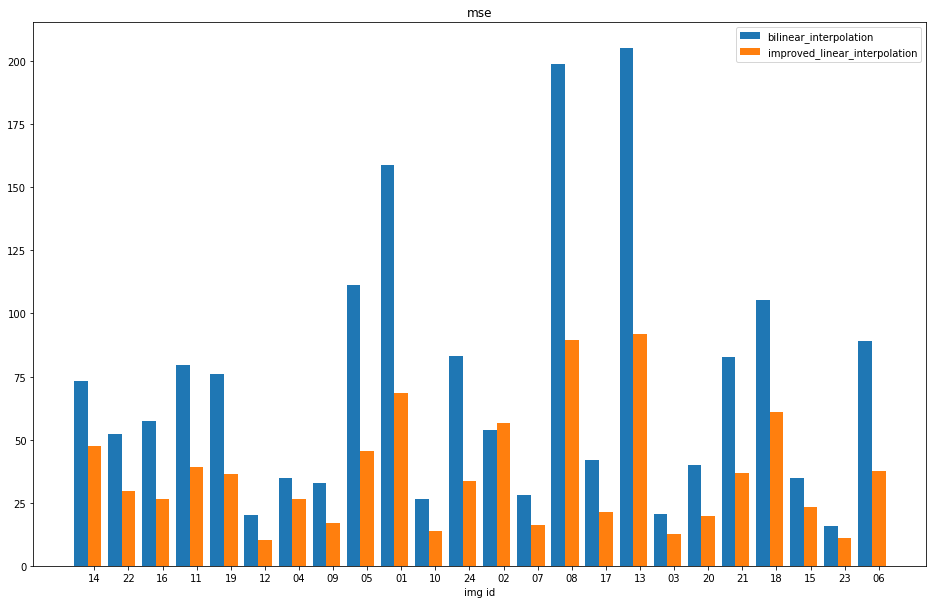

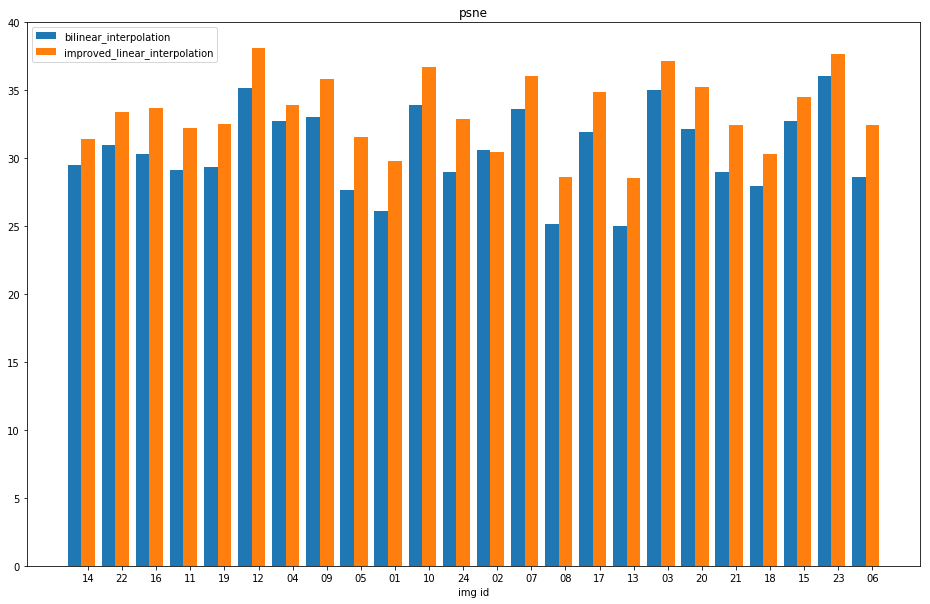

bilinear_interpolation:
  avg mse:  71.7
  avg psne: 30.6
improved_linear_interpolation:
  avg mse:  36.3
  avg psne: 33.3


In [21]:
for i, title in zip((0, 1), ('mse', 'psne')):
    plt.figure(figsize=(16, 10))
    plt.bar(
        np.arange(24)-0.2,
        list(map(lambda x: x[i], results.values())),
        width=0.4,
        label='bilinear_interpolation'
    )
    plt.bar(
        np.arange(24)+0.2,
        list(map(lambda x: x[i], results2.values())),
        width=0.4,
        tick_label=list(map(lambda s: s[5:7], results2.keys())),
        label='improved_linear_interpolation'
    )
    plt.title(title)
    plt.xlabel('img id')
    plt.legend()
    plt.show()

print('bilinear_interpolation:')
print('  avg mse:  {:0.3}\n  avg psne: {:0.3}'.format(*np.array([*results.values()]).mean(axis=0)))
print('improved_linear_interpolation:')
print('  avg mse:  {:0.3}\n  avg psne: {:0.3}'.format(*np.array([*results2.values()]).mean(axis=0)))


In [278]:
for filename in os.listdir(RAW_DIR):
    gt_image = skimage.io.imread(os.path.join(GT_DIR, filename))
    bi_image = skimage.io.imread(os.path.join(OUTPUT_DIR, filename))
    ili_image = skimage.io.imread(os.path.join(OUTPUT_DIR2, filename))
    for img, title in zip((gt_image, bi_image, ili_image), ('ground truth', 'bilinear', 'improved')):
        plt.figure(figsize=(15, 15))
        plt.imshow(img)
        plt.title(' '.join([filename[5:7], title]))
        plt.show()

**Выводы: **

В работе были рассмотрены два линейных метода домозаикинга. Наивный с ядром 3 на 3 и улучшенный с ядром 5 на 5, учитывающий корреляцию между цветами.

Оба метода хорошо восстанавливают цвет монотонных областей, но ни одни не может восстановить высокочастотные области без артефактов. Судя по метрике mse второй способ в 1.5 - 2 раза лучше первого, но визуально отличий практически не заметно.